In [62]:
!pip install transformers

In [7]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 4.9 MB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 17.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 8.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 17.9 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 6.5 MB/s eta 0:00:00m eta 0:00:010:00:01


In [4]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 4.0 MB/s eta 0:00:000:00:01m eta 0:00:01


In [64]:
import pandas as pd
import transformers
import transformers
from transformers import BertModel, BertTokenizer, TFBertModel, TFBertForSequenceClassification, BertConfig, AdamW, get_linear_schedule_with_warmup
import torch
import re
from transformers import AutoTokenizer
import torch
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
#from pandas_profiling import ProfileReport
from wordcloud import WordCloud, STOPWORDS

In [9]:
print(torch.__version__)
print(transformers.__version__)

1.13.1+cu117
4.26.1


In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [4]:
df_train.sample(2)

id      keyword      location  \
240    341  annihilated           NaN   
3870  5502       flames  Fairy Tail!    

                                                                                                                                          text  \
240   @thatdes ok i wasn't completely forthright i may have also been in a food coma bc of the kebab/tahini/pickles i also annihilated w/fries   
3870        @AisuMage @AkumaReisu --just between Gray and Ophelia red flames blazing around her person setting nearly everything in the area--   

      target  
240        0  
3870       1

In [5]:
df_train.describe()

id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

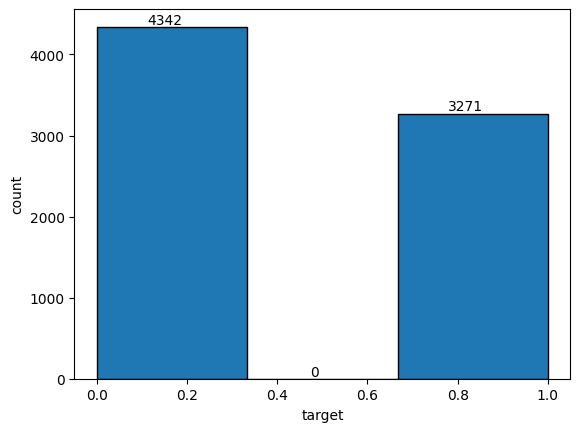

In [6]:
counts, bins, _ = plt.hist(df_train['target'], bins=3, edgecolor='black')

#print(_)
# add text to each bar
for i in range(len(counts)):
   # print(i)
    plt.text(bins[i]+0.15, counts[i]+0.5, int(counts[i]), ha='center', va='bottom')

# set the x and y axis labels
plt.xlabel('target')
plt.ylabel('count')

# display the plot
plt.show()


In [7]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
profile = ProfileReport(df_train, title="Pandas Profiling Report")
profile.to_notebook_iframe()

NameError: name 'ProfileReport' is not defined

In [10]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
# drop location data
clean_train = df_train.drop(columns="location")
clean_test = df_test.drop(columns="location")

In [24]:
clean_train.sample(10)

id    keyword  \
6139  8758      siren   
4113  5845  hailstorm   
3541  5063     famine   
790   1145     blight   
73     105   accident   
763   1104  blew%20up   
2399  3451     derail   
6843  9806    trapped   
1956  2817    cyclone   
5628  8028   refugees   

                                                                                                                         text  \
6139  So when r u getting married'@Foxy__Siren: Oh finally Jennifer Aniston got married??????... I'm so happy for her ??????'   
4113                                          @AdriaSimon_: Hailstorm day 2.... #round2 #yyc #yycstorm http://t.co/FqQI8GVLQ4   
3541                                  'Food crematoria' provoke outrage amid crisis famine memories... http://t.co/fABVlvN5MS   
790       Carl Everest Rob Cobes Whitt Blight Frost Leo Snuff Godly and a few others. I will drink a beer with them. Someday.   
73                                                                                        BigRigRadio Live Accident Awareness   
763                                                                                       I blew up snapchat for no reason ??   
2399                              Here's what may have caused a Metro train to derail in downtown D.C. http://t.co/mEiSNKv5Tb   
6843                                            Hollywood movie about trapped miners released in Chile http://t.co/xe0EE1Fzfh   
1956                                     @XHNews We need these plants in the pacific during the cyclone seasons it would help   
5628                                      y'all read 12000 Nigerian refugees repatriated from Cameroon http://t.co/aVwE1LBvhn   

      target  
6139       0  
4113       1  
3541       1  
790        0  
73         1  
763        0  
2399       1  
6843       0  
1956       1  
5628       1

In [12]:
clean_train.shape

(7613, 4)

222 unique words in the keyword column for train data.


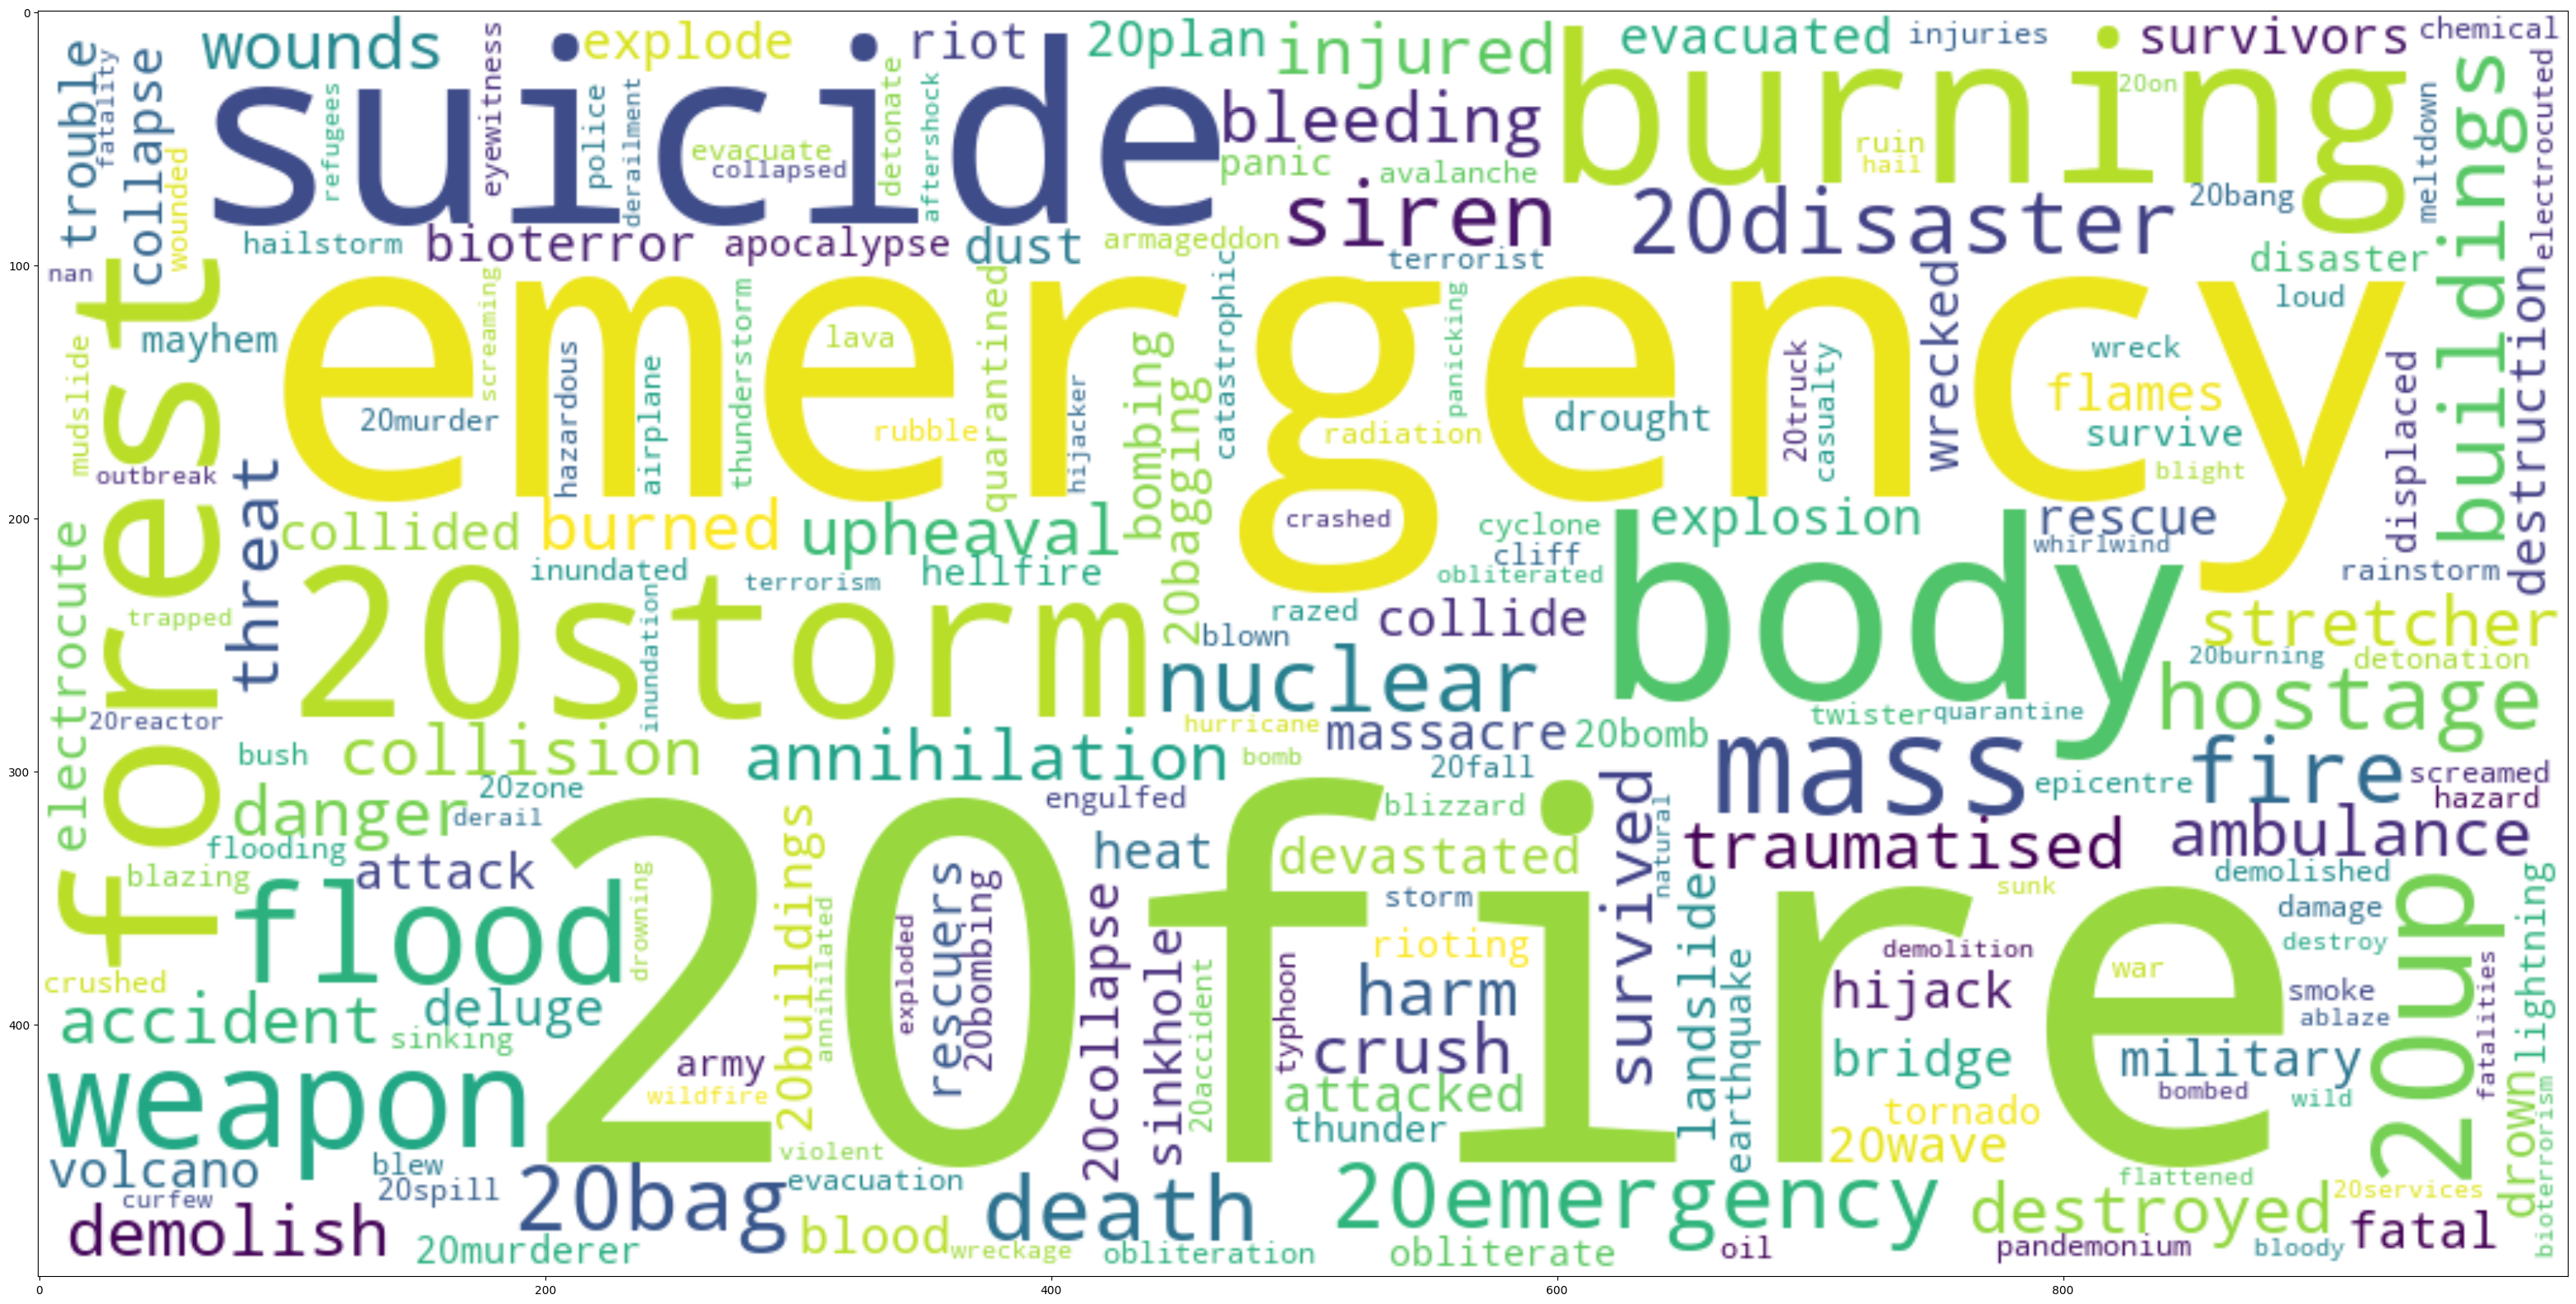

In [13]:
text = " ".join(set(word for word in clean_train['keyword'].astype(str)))
print(f"{len(set(text.split()))} unique words in the keyword column for train data.")
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=1000, height=500).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

222 unique words in the keyword column for Test data.


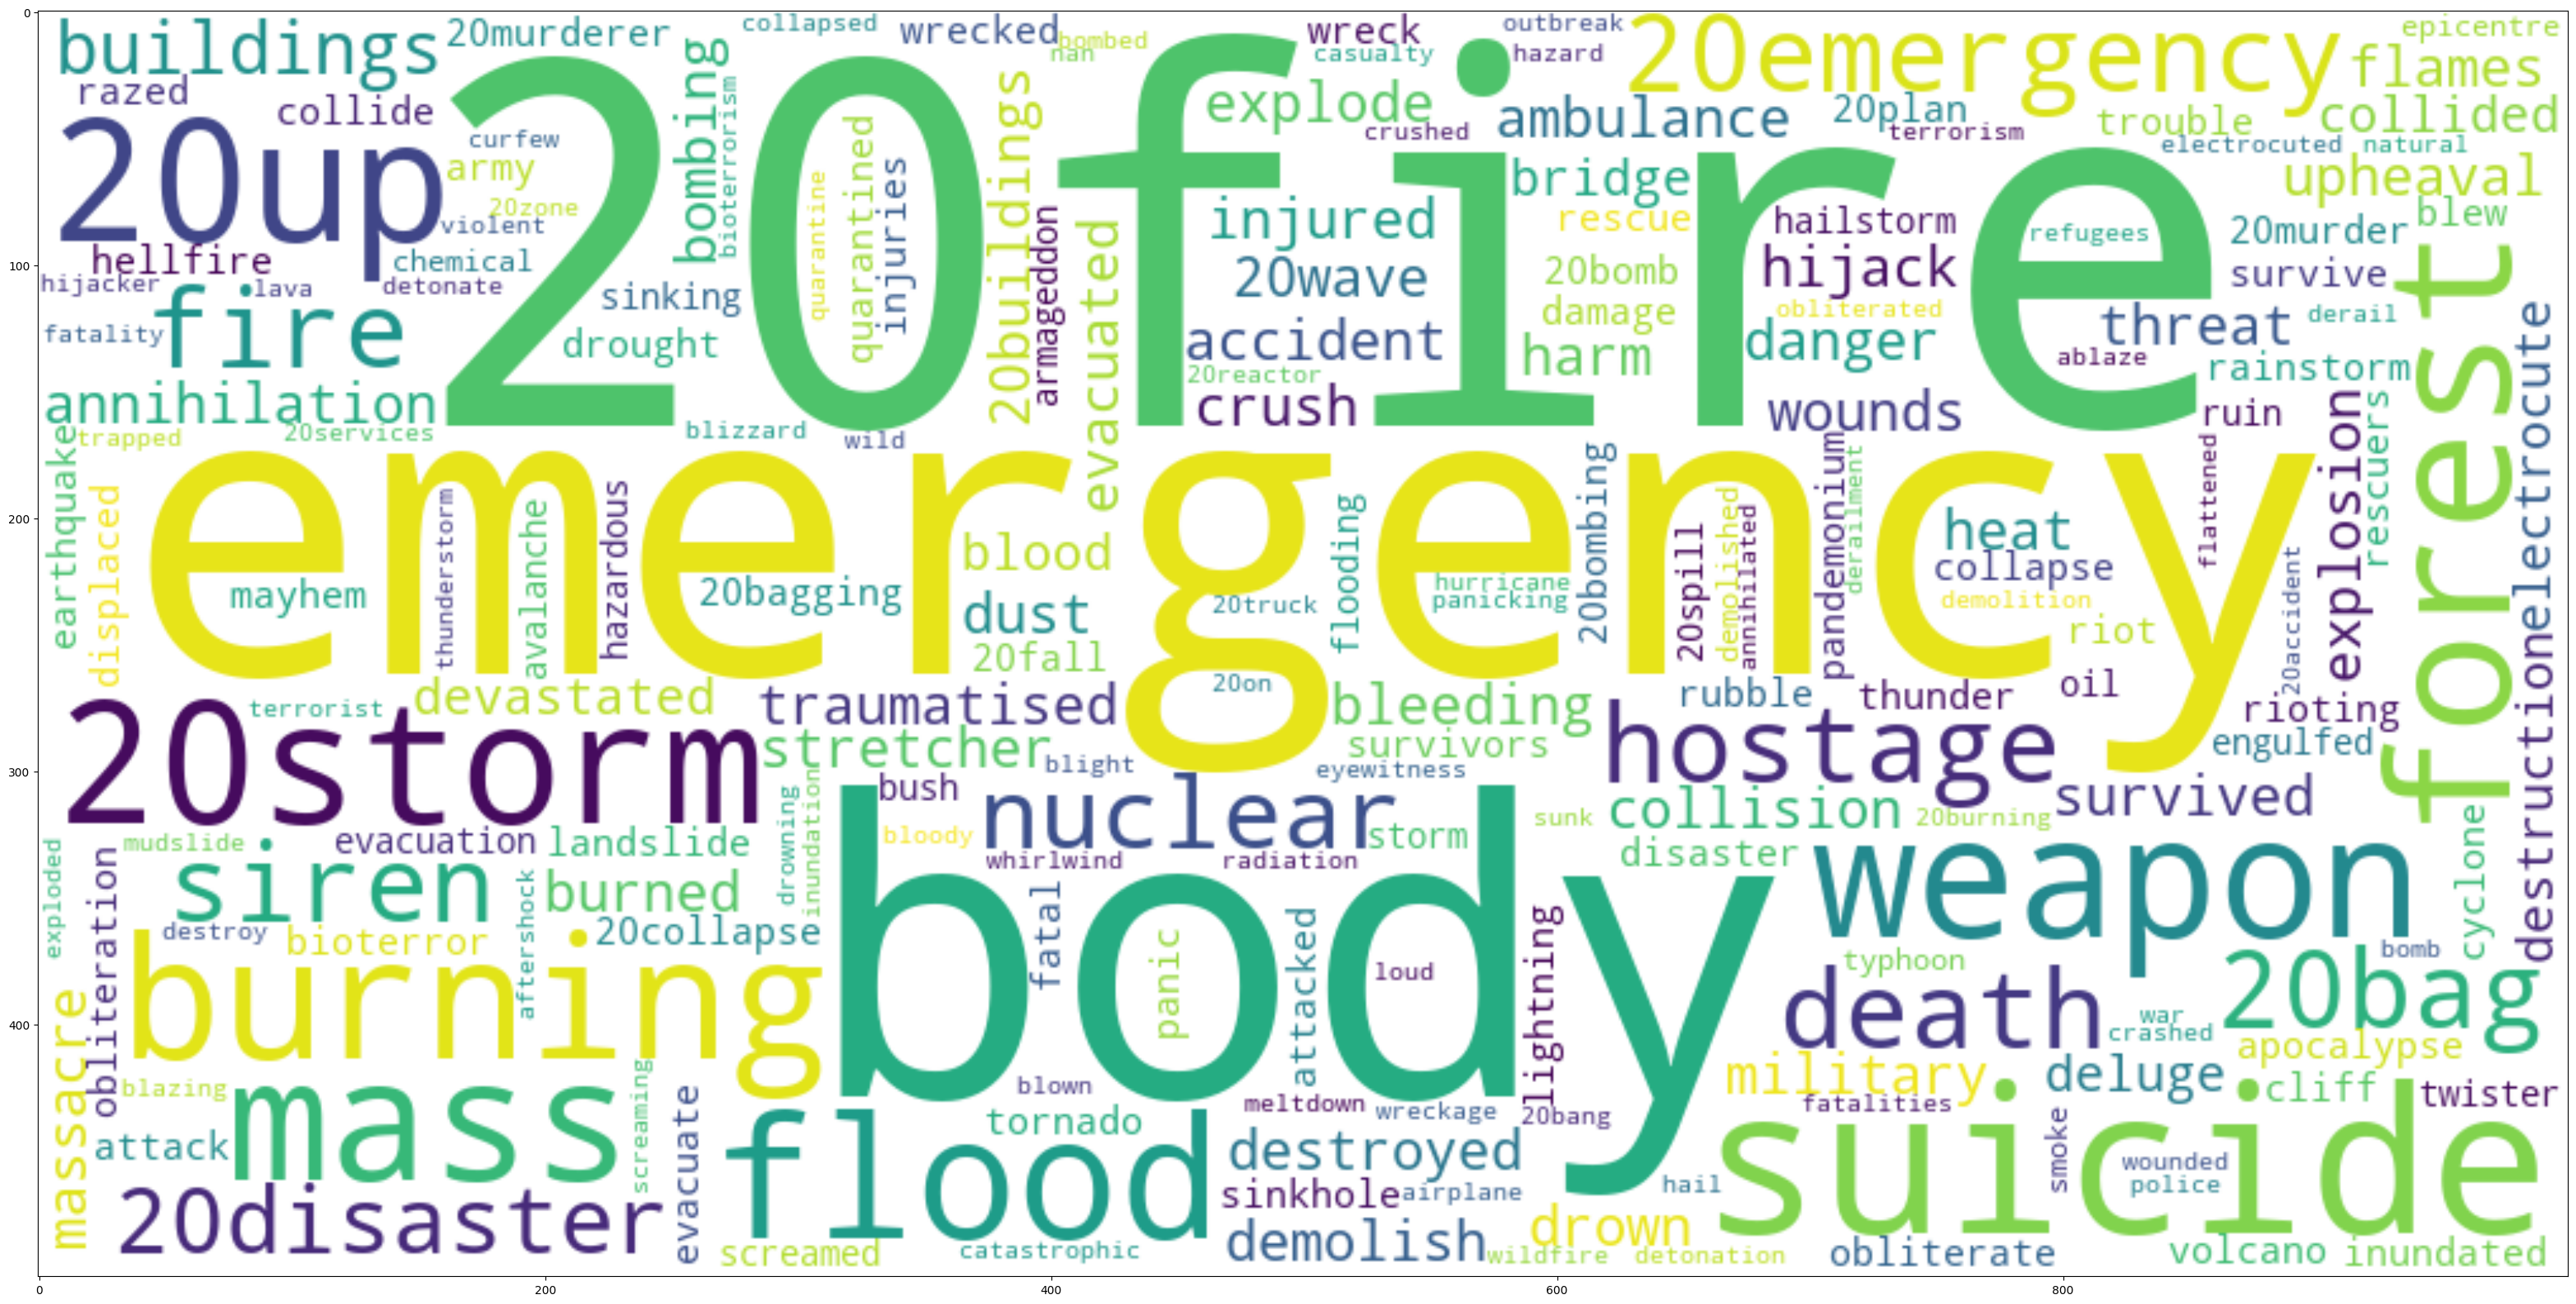

In [14]:
text = " ".join(set(word for word in clean_test['keyword'].astype(str)))
print(f"{len(set(text.split()))} unique words in the keyword column for Test data.")
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=1000, height=500).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [15]:
clean_train = clean_train.dropna(subset=['keyword']).reset_index(drop=True)

In [16]:
# we fill none into the Nan Values, to give 0 sentiment
clean_test['keyword'] = clean_test['keyword'].fillna("None")

In [31]:
clean_train

id  keyword  \
0        48   ablaze   
1        49   ablaze   
2        50   ablaze   
3        52   ablaze   
4        53   ablaze   
...     ...      ...   
7547  10830  wrecked   
7548  10831  wrecked   
7549  10832  wrecked   
7550  10833  wrecked   
7551  10834  wrecked   

                                                                                                             text  \
0                                                         @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C   
1                                             We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw   
2                              #AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi   
3                                                                              Crying out for more! Set me ablaze   
4                                    On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N   
...                                                                                                           ...   
7547                                                             @jt_ruff23 @cameronhacker and I wrecked you both   
7548  Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family for that one   
7549                #FX #forex #trading Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/7enNulLKzM   
7550     @engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO   
7551                             Cramer: Iger's 3 words that wrecked Disney's stock - CNBC http://t.co/N6RBnHMTD4   

      target  
0          1  
1          0  
2          1  
3          0  
4          0  
...      ...  
7547       0  
7548       0  
7549       0  
7550       0  
7551       0  

[7552 rows x 4 columns]

In [19]:
df_nondupes = clean_train_data.groupby(['text']).nunique().sort_values(by='target', ascending=False)

In [38]:
df_nondupes = clean_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_nondupes.sample(2)

id  \
text                                                                                                                                            
@peterjukes But there are good grounds to believe that 'political military catastrophe' was a crime planned and committed by individuals.   1   
@BrookTekle_ didn't look like a murder scene just 1 cops a fire truck and 2 fire assistance cars along with a helicopter                    1   

                                                                                                                                           keyword  \
text                                                                                                                                                 
@peterjukes But there are good grounds to believe that 'political military catastrophe' was a crime planned and committed by individuals.        1   
@BrookTekle_ didn't look like a murder scene just 1 cops a fire truck and 2 fire assistance cars along with a helicopter                         1   

                                                                                                                                           target  
text                                                                                                                                               
@peterjukes But there are good grounds to believe that 'political military catastrophe' was a crime planned and committed by individuals.       1  
@BrookTekle_ didn't look like a murder scene just 1 cops a fire truck and 2 fire assistance cars along with a helicopter                        1

In [40]:
# check for duplicates using groupby
df_nondupes = clean_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_dupes = df_nondupes[df_nondupes['target'] > 1]
df_dupes.rename(columns={'id':'# of duplicates', 'target':'sum of target var'})

# of duplicates  \
text                                                                                                                                                           
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit                              2   
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife                                                       3   
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                                         6   
To fight bioterrorism sir.                                                                                                                                 4   
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                                6   
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!                                                     2   
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE                3   
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect                 3   
wowo--=== 12000 Nigerian refugees repatriated from Cameroon                                                                                                2   
RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG                                                             2   
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4                     4   
Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...                                                                       2   
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption                                      3   
CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring                                                                   3   
Caution: breathing may be hazardous to your health.                                                                                                        2   
I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????                                                                         2   
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time                          4   
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!                                         2   

                                                                                                                                             keyword  \
text                                                                                                                                                   
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit                      2   
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife                                               1   
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                                 1   
To fight bioterrorism sir.                                                                                                                         1   
He came to a land which was 

In [45]:
clean_train = clean_train.drop_duplicates(subset=['text'], keep='last').reset_index(drop=True)

In [46]:
clean_train.sample(2)

id     keyword  \
3907  5680      floods   
935   1408  body%20bag   

                                                                                                                                             text  \
3907                        Typhoon Soudelor approaches after 7 killed 2 missing in floods in Philippines http://t.co/nJMiDySXoF via @abc7chicago   
935   New Women Handbag Faux Leather Ladies Shoulder Tote Cross Body Bag Large Satchel - Full reÛ_ http://t.co/NCjPGf6znv http://t.co/GeRJau74eY   

      target  
3907       1  
935        0

In [50]:
# we save these as pickles
clean_train.to_pickle("pickles/clean_train_data.pkl")
clean_test.to_pickle("pickles/clean_test_data.pkl")

In [51]:
# download pickles
train_df = pd.read_pickle("pickles/clean_train_data.pkl")
test_df = pd.read_pickle("pickles/clean_test_data.pkl")

In [52]:
def clean_text(text):
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    # remove unicode characters
    text =text.encode('ascii', 'ignore').decode()
    # Remove URLs
    text = re.sub(r'https*\S+', ' ', text)
    text = re.sub(r'http*\S+', ' ', text)
    
    return text

In [53]:

train_df['cleaned_text'] = train_df.text.apply(clean_text)
test_df['cleaned_text'] = test_df.text.apply(clean_text)

In [55]:
list(train_df['cleaned_text'].sample(20))


['tornado has to make the playoffs they have 3 guys with 20homers already and they just added tulowitzki and price',
 'if you have a son or a daughter would you like to see them going to a war with iran and come back in a body bag let the republicans know',
 'im glad when i call someone its not an emergency since they never answer their phones or call back',
 'sassy city girl country hunk stranded in smoky mountain snowstorm aoms   ibooklove bookboost',
 'photo this is why i am scared to leave my car under trees in a storm jamaicaplain boston hailstorm  ',
 'hes blazing through this game with the best stealth skills yet nothing beats the silenced m4',
 '93 blasts accused yeda yakub dies in karachi of heart attack   mumbai',
 'dont let others bring you down no matter how hard they try beconfident dont let others destroy you with your weaknesses',
 'absurdly ridiculous mens fashion to demolish you manhood  ',
 'i forgot to add the burning buildings and screaming babies',
 'who said this 

In [57]:
# create final dfs without text col
final_train_df = train_df.drop(columns=['text', 'id'])
final_test_df = test_df.drop(columns=['text', 'id'])

# save labels
train_labels = final_train_df['target']

# separate clean text
train_text = final_train_df['cleaned_text']
test_text = final_test_df['cleaned_text']

In [65]:
# we use a pre-trained bert model to tokenize the text
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [9]:
# Apply the clean_text function to the 'tweet' column
df['text'] = df_tweet['text'].apply(clean_text)

In [10]:
df['text'].head(2)

0    our deeds are the reason of this earthquake may allah forgive us all
1                                   forest fire near la ronge sask canada
Name: text, dtype: object

In [11]:
# Load the tokenizer for a specific pre-trained model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [13]:
def tokenize_tweet(tweet):
    tokenized_tweet = tokenizer.encode_plus(tweet, add_special_tokens=True, 
                                             return_attention_mask=True, 
                                             return_tensors='pt')
    return tokenized_tweet

In [17]:
# Apply the tokenize_tweet function to the 'tweet' column
df['tokenized_tweet'] = df['text'].apply(tokenize_tweet)

# Print the original and tokenized tweet columns
print(df['tokenized_tweet'])

0       [input_ids, token_type_ids, attention_mask]
1       [input_ids, token_type_ids, attention_mask]
2       [input_ids, token_type_ids, attention_mask]
3       [input_ids, token_type_ids, attention_mask]
4       [input_ids, token_type_ids, attention_mask]
                           ...                     
7608    [input_ids, token_type_ids, attention_mask]
7609    [input_ids, token_type_ids, attention_mask]
7610    [input_ids, token_type_ids, attention_mask]
7611    [input_ids, token_type_ids, attention_mask]
7612    [input_ids, token_type_ids, attention_mask]
Name: tokenized_tweet, Length: 7613, dtype: object


In [13]:
tokenizer.decode(df["input_ids"])

KeyError: 'input_ids'